<div align="center">
<a href="https://vbti.nl"><img src="./images/vbti_logo.png" width="400"></a>
</div>

In the previous section we had a look at the improvement of DQN algorithm - Double DQN, that helps to overcome the **maximization bias**. We could achieve faster training times, but it still had a shortcoming of not recognizing the advantage of an action in comparison to other actions.

# Dueling Architecture <a href="https://arxiv.org/pdf/1511.06581.pdf">[paper]</a>


The dueling architecture exploits the idea that for many states, it is unnecessary to estimate the Value of each action choice. For example, in Seaquest moving or shooting is only needed when the enemy is in sight. In other words, this architecture emphasizes the actions that are better in comparison with other actions.

<img src="images/dueling.png" width=600>

The last dense layers will have two streams: the Value and the Advantage stream. The Value estimate tells us how good a particular state is, while Advantage focuses on the advantage of one action with respect to the others. Combining those two steams together provides the same q-value estimate.
$$Q(s, a;\theta) = V(s;\theta) + A(s, a;\theta)$$

Even though it is an attractive and straightforward way of combining Value and Advantage streams it leads to poor performance. This can be explained by the fact that $V(s;\theta)$ and $Q(s, a;\theta)$ are not the true values, but the estimates. It is tough to make good adjustments to those estimates since we don't know the contribution of each term (if we add a constant to $V(a; \theta)$ and subtract the same constant from $A(s, a; \theta)$ it will cancel out resulting in the same $Q(s, a;\theta))$.

To solve this problem, the authors propose a different way of combining the Value and Advantage streams.
$$Q(s, a;\theta) = V(s; \theta) + (A(s, a; \theta) - \frac{1}{|\mathcal{A}|} \sum_{a'} A(s, a';\theta))$$

Now, the value estimation is tied to the average advantage of all actions, consequently improving the stability of an algorithm.

To make the corresponding changes to the code, we are going to extend ```DoubleDQN``` class and override ```create_model``` method.


```python

class DuelingDDQN(DoubleDQN):
    def create_model(self, model_name):
        input_state = tf.keras.Input(shape=self.state_shape,
                                     batch_size=None,
                                     name='state_input',
                                     dtype=tf.uint8)

        x = tf.divide(tf.cast(input_state, dtype=tf.float32), tf.constant(255., dtype=tf.float32))

        x = Conv2D(16, kernel_size=(8, 8), strides=(4, 4),
                   padding='valid', activation='relu', name='conv1')(x)
        x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2),
                   padding='valid', activation='relu', name='conv2')(x)
        x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                   padding='valid', activation='relu', name='conv3')(x)

        x = Flatten()(x)

        x = Dense(512, activation='tanh', name='hidden_dense')(x) 
        
        # V(s)
        value = Dense(1, activation='linear', name='hidden_dense_value')(x)
        # A(s, a)
        advantage = Dense(self.n_actions, activation='linear', name='dense_advantage')(x)
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        q_values = value + tf.subtract(advantage, tf.reduce_mean(advantage, axis=1, keepdims=True))
        
        q_network = Model(inputs=[input_state], outputs=[q_values], name=model_name)
        
        return q_network
```

In [ ]:
%load_ext autoreload
%autoreload 2

def set_gpu(idxs=None):
    """Set visible GPUs
    ids: list of GPU ids to be visible, None to disble all GPUs
    """
    import tensorflow as tf
    gpu_devices = [x for x in tf.config.list_physical_devices() if x.device_type=='GPU']
    
    idxs = idxs or []
    set_visible = [gpu_devices[idx] for idx in idxs]
    
    try:
        # Disable all GPUS
        tf.config.set_visible_devices(set_visible, 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    finally:
        print(tf.config.get_visible_devices())
        
# Disable GPUs        
set_gpu(idxs=None)

## Seaquest
### Loading

In [1]:
from os.path import join

import gym

from QLearning.dqn import EpsilonGreedyAgent, DuelingDDQN
from QLearning.env_wrappers import AtariFrameStack

EXPERIMENT_FOLDER = join('Experiments', 'seaquest_dueling_ddqn')

env = AtariFrameStack(gym.make('SeaquestNoFrameskip-v4'))
q_network = DuelingDDQN(
    state_shape=env.observation_space.shape,
    n_actions=env.action_space.n,
)
# Load the network
q_network.load(join(EXPERIMENT_FOLDER, 'latest'))

agent = EpsilonGreedyAgent(n_actions=env.action_space.n, network=q_network, start_epsilon=0.02)

In [2]:
from QLearning.dqn import run_episode

video_path = join(EXPERIMENT_FOLDER, 'videos')
                  
env = gym.wrappers.Monitor(env, video_path, force=True)
print(run_episode(env, agent, train=False))
env.close()

{'score': 6330.0, 'steps_per_game': 2772, 'framerate': 179.4765422019715, 'runs': 0, 'return': 0, 'epsilon': 0.02, 'loss': 0, 'steps': 0}


In [3]:
from IPython.display import Video
import os

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name), embed=True)

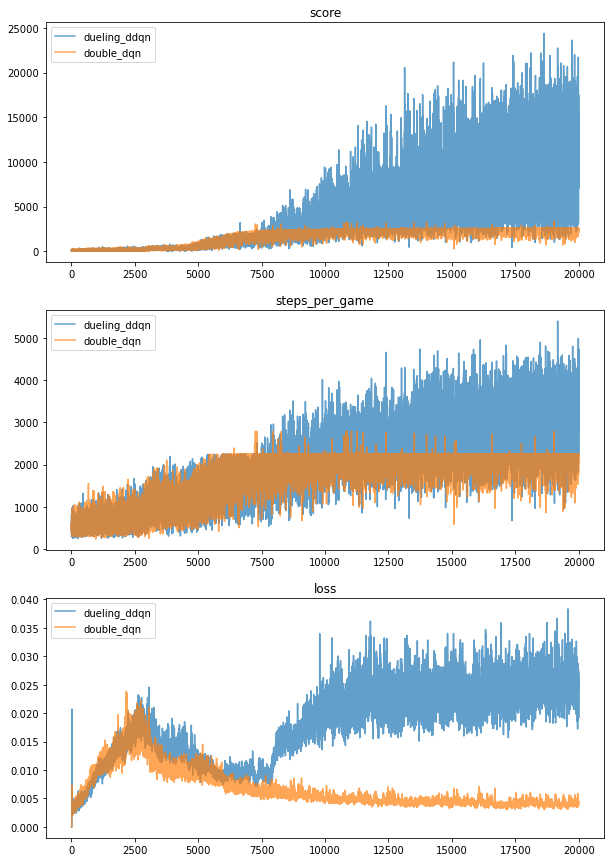

In [1]:
from QLearning.dqn import load_history, plot_history
import matplotlib.pyplot as plt

from os.path import join

history_double_dqn = load_history(join('Experiments', 'seaquest_double_dqn', 'history.json'))
history_dueling_ddqn = load_history(join('Experiments', 'seaquest_dueling_ddqn', 'history.json'))

elems = ['score', 'steps_per_game', 'loss']
plot_history([history_dueling_ddqn, history_double_dqn], elems, names=['dueling_ddqn', 'double_dqn'])

In [4]:
from IPython.display import Video
from os.path import join
Video(join("Experiments", "atari_recordings", "dueling_dqn_seaquest.mp4"), embed=True)

### Training

In [5]:
import gym
from QLearning.env_wrappers import AtariFrameStack
from QLearning.dqn import DuelingDDQN, EpsilonGreedyAgent

from os.path import join


EXPERIMENT_FOLDER = join('Experiments', 'seaquest_dueling_ddqn_01')
save_interval = 500
video_folder = join(EXPERIMENT_FOLDER, 'video')

env = AtariFrameStack(gym.make('SeaquestNoFrameskip-v4'),
                      frame_skip=4,
                      terminal_on_life_loss=False,
                      screen_size=84,
                      stack_size=4,
                      skip_init=20)
env = gym.wrappers.Monitor(env, video_folder, force=True,
                          video_callable=lambda episode_id: episode_id % save_interval == 0)
        
print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

q_network = DuelingDDQN(state_shape=env.observation_space.shape,
                        target_network_update_freq=8000,
                         n_actions=env.action_space.n,
                         learning_rate=6.25e-5,
                         gamma=0.99)

agent = EpsilonGreedyAgent(n_actions=env.action_space.n,
                   network=q_network,
                   replay_capacity=50000,
                   gamma=0.99,  # discount of future rewards
                   training_start=10000,  # start training after x number of steps
                   training_interval=4,  # train every x steps
                   batch_size=32,
                   start_epsilon=1.0,
                   end_epsilon=0.02,
                   epsilon_decay=2e-7,
                   root_folder=EXPERIMENT_FOLDER,
                   save_best=True,
                   save_interval=save_interval)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

Observation space: Box(0, 255, (84, 84, 4), uint8)
Action space: Discrete(18)


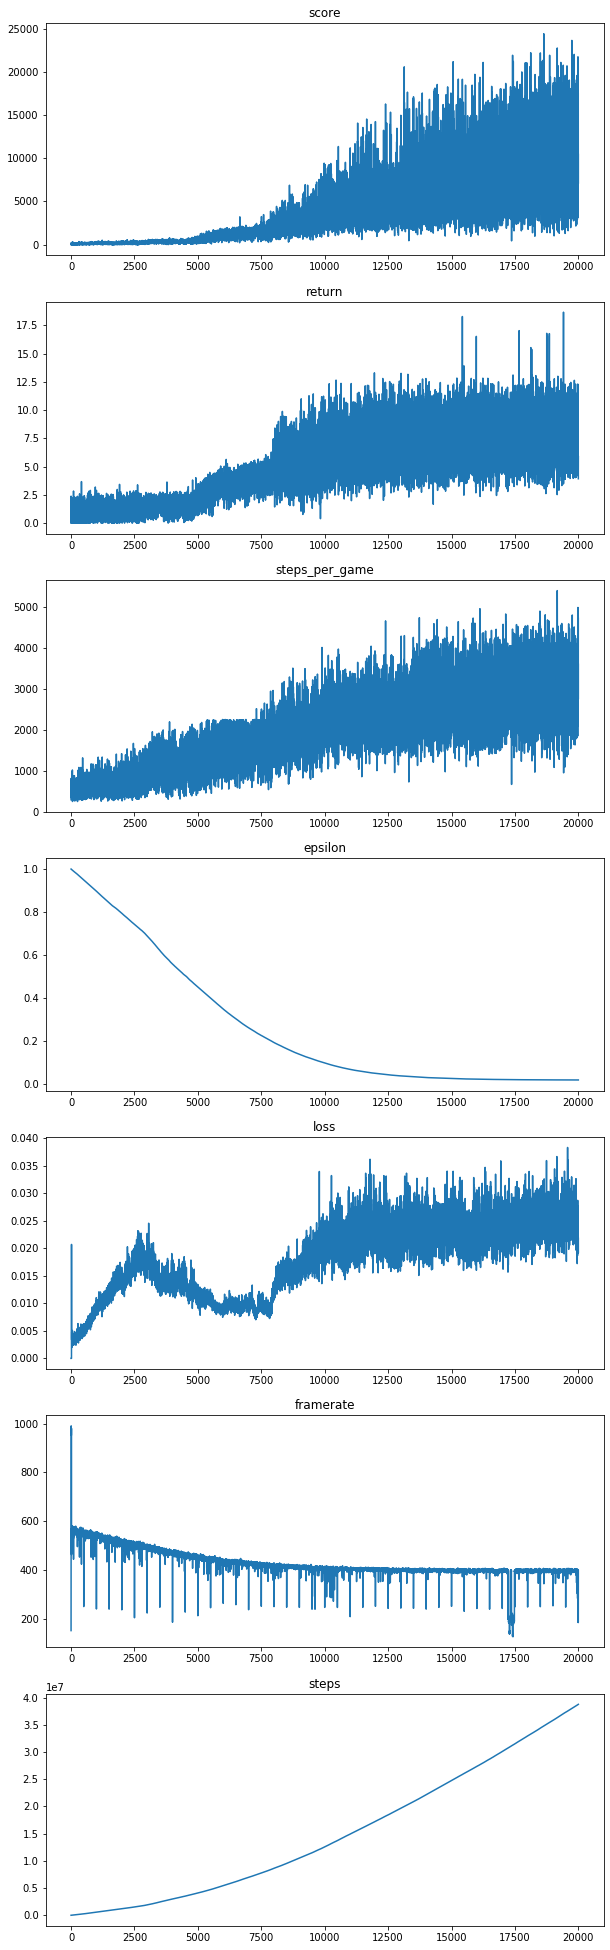

In [25]:
run_experiment(env, agent, runs=20000, history=history,
              plot_stats=[
                   'score',
                   'return',
                   'steps_per_game',
                   'epsilon',
                   'loss',
                   'framerate',
                   'steps'
               ])
env.close()

In [27]:
from os.path import join
import json
# Save the model and dump the history file
agent.save_model(join(EXPERIMENT_FOLDER, 'latest'))
json.dump(str(history), open(join(EXPERIMENT_FOLDER, 'history.json'), 'w'))

INFO:tensorflow:Assets written to: seaquest_dueling_ddqn_more_exploration/latest/assets
